In [1]:
import requests
import pandas as pd
from time import sleep
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Import API key from config file
from config import TMDB_API_KEY

# Get API key: from environment variable or config file
api_key = os.getenv("TMDB_API_KEY") or TMDB_API_KEY

# TMDB base URL
base_url = "https://api.themoviedb.org/3"


In [3]:
def fetch_movie_data(movie_id):
    """Fetch movie details from TMDB API."""
    url = f"{base_url}/movie/{movie_id}"
    params = {
        "api_key": api_key,
        "language": "en-US"
    }
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data for movie ID {movie_id}: {response.status_code}")
        try:
            print(response.json())  # Print error details from API
        except:
            pass
        return None

def main():
    """Main pipeline to fetch movies and build a DataFrame."""
    # Example movie IDs (test small batch first)
    movie_ids = [550, 551, 552, 553, 554]
    
    movie_data_list = []

    for movie_id in movie_ids:
        movie_data = fetch_movie_data(movie_id)
        if movie_data:
            print("\n🔍 API Response for Movie ID:", movie_id)
            print(json.dumps(movie_data, indent=4))  # Pretty print JSON for clarity
            
            movie_data_list.append(movie_data)
        sleep(1)  # Be respectful of rate limits

    # Convert to DataFrame
    if movie_data_list:
        df = pd.DataFrame(movie_data_list)

        print("\n Fetched Movie DataFrame:")
        print(df.head())

        print("\n DataFrame Columns:")
        print(df.columns)

        # Save DataFrame (optional)
        # df.to_csv("tmdb_movies_raw.csv", index=False)

    else:
        print("No movie data fetched.")

if __name__ == "__main__":
    main()



🔍 API Response for Movie ID: 550
{
    "adult": false,
    "backdrop_path": "/xRyINp9KfMLVjRiO5nCsoRDdvvF.jpg",
    "belongs_to_collection": null,
    "budget": 63000000,
    "genres": [
        {
            "id": 18,
            "name": "Drama"
        }
    ],
    "homepage": "http://www.foxmovies.com/movies/fight-club",
    "id": 550,
    "imdb_id": "tt0137523",
    "origin_country": [
        "US"
    ],
    "original_language": "en",
    "original_title": "Fight Club",
    "overview": "A ticking-time-bomb insomniac and a slippery soap salesman channel primal male aggression into a shocking new form of therapy. Their concept catches on, with underground \"fight clubs\" forming in every town, until an eccentric gets in the way and ignites an out-of-control spiral toward oblivion.",
    "popularity": 25.3225,
    "poster_path": "/pB8BM7pdSp6B6Ih7QZ4DrQ3PmJK.jpg",
    "production_companies": [
        {
            "id": 711,
            "logo_path": "/tEiIH5QesdheJmDAqQwvtN60727.pn

In [4]:
url = f"https://api.themoviedb.org/3/discover/movie"
params = {
    "api_key": api_key,
    "language": "en-US",
    "primary_release_date.gte": "2000-01-01",
    "primary_release_date.lte": "2024-12-31",
    "page": 1
}

response = requests.get(url, params=params)
data = response.json()

print(f"Total movies matching query: {data['total_results']}")
print(f"Total pages: {data['total_pages']}")


Total movies matching query: 579194
Total pages: 28960


In [ ]:
#  Storage for results
movie_data = []

# Loop through TMDB's /discover/movie endpoint
for page in range(1, 400):  # Start with 2 pages for quick testing; increase to 201 later
    discover_url = f"{base_url}/discover/movie"
    params = {
        "api_key": api_key,
        "language": "en-US",
        "sort_by": "popularity.desc",
        "include_adult": False,
        "include_video": False,
        "page": page,
        "primary_release_date.gte": "2000-01-01",
        "primary_release_date.lte": "2024-12-31"
    }

    response = requests.get(discover_url, params=params)
    if response.status_code != 200:
        print(f"Failed on page {page} — Status: {response.status_code}")
        print(response.json())  # Show error
        break

    movies = response.json().get("results", [])

    for movie in movies:
        movie_id = movie["id"]

        # Fetch movie details
        movie_details = requests.get(f"{base_url}/movie/{movie_id}", params={"api_key": api_key}).json()
        credits = requests.get(f"{base_url}/movie/{movie_id}/credits", params={"api_key": api_key}).json()

        # Get director and top actor
        director = next((c["name"] for c in credits.get("crew", []) if c["job"] == "Director"), None)
        cast = [c["name"] for c in credits.get("cast", [])][:1]

        # Collect relevant fields
        movie_data.append({
            "title": movie_details.get("title"),
            "release_date": movie_details.get("release_date"),
            "budget": movie_details.get("budget"),
            "revenue": movie_details.get("revenue"),
            "runtime": movie_details.get("runtime"),
            "genres": [g["name"] for g in movie_details.get("genres", [])],
            "popularity": movie_details.get("popularity"),
            "vote_average": movie_details.get("vote_average"),
            "vote_count": movie_details.get("vote_count"),
            "original_language": movie_details.get("original_language"),
            "production_companies": [pc["name"] for pc in movie_details.get("production_companies", [])],
            "belongs_to_collection": movie_details.get("belongs_to_collection") is not None,
            "director": director,
            "lead_actor": cast[0] if cast else None
        })

    print(f"Page {page} complete — movies collected: {len(movie_data)}")
    sleep(0.3)

# Convert to DataFrame
df_movies = pd.DataFrame(movie_data)

# Print the DataFrame
df_movies.head() # Preview first few rows


Page 1 complete — movies collected: 20
Page 2 complete — movies collected: 40
Page 3 complete — movies collected: 60
Page 4 complete — movies collected: 80
Page 5 complete — movies collected: 100
Page 6 complete — movies collected: 120
Page 7 complete — movies collected: 140
Page 8 complete — movies collected: 160
Page 9 complete — movies collected: 180
Page 10 complete — movies collected: 200
Page 11 complete — movies collected: 220
Page 12 complete — movies collected: 240
Page 13 complete — movies collected: 260
Page 14 complete — movies collected: 280
Page 15 complete — movies collected: 300
Page 16 complete — movies collected: 320
Page 17 complete — movies collected: 340
Page 18 complete — movies collected: 360
Page 19 complete — movies collected: 380
Page 20 complete — movies collected: 400
Page 21 complete — movies collected: 420
Page 22 complete — movies collected: 440
Page 23 complete — movies collected: 460
Page 24 complete — movies collected: 480
Page 25 complete — movies col

,title,budget,revenue,runtime,genres,popularity,vote_average,vote_count,original_language,production_companies,belongs_to_collection,director,lead_actor
0,The Last Stand of Ellen Cole,0,0,92,"[Action, Adventure]",246.3657,8.281,16,en,"[Regency Enterprises, QCODE, Automatik Enterta...",False,Derek Lee,Lin Shaye
1,Avengers: Infinity War,300000000,2052415039,149,"[Adventure, Action, Science Fiction]",204.1534,8.236,30594,en,[Marvel Studios],True,Joe Russo,Robert Downey Jr.
2,Spider-Man: Homecoming,175000000,880166924,133,"[Action, Adventure, Science Fiction, Drama]",172.1237,7.331,22236,en,"[Marvel Studios, Pascal Pictures, LStar Capita...",True,Jon Watts,Tom Holland
3,The Suicide Squad,185000000,168717425,132,"[Action, Comedy, Adventure]",181.7728,7.486,8922,en,"[DC Films, Atlas Entertainment, The Safran Com...",True,James Gunn,Margot Robbie
4,Black Panther,200000000,1349926083,135,"[Action, Adventure, Science Fiction]",175.7277,7.373,22587,en,[Marvel Studios],True,Ryan Coogler,Chadwick Boseman


In [7]:
df_movies = df_movies[(df_movies['budget'] != 0) & (df_movies['revenue'] != 0)]

df_movies['profit'] = df_movies['revenue'] - df_movies['budget']
df_movies['profit_margin'] = df_movies['profit'] / df_movies['revenue']
print("\nFinal DataFrame with Profit and Profit Margin:")
print(df_movies[['title', 'budget', 'revenue', 'profit', 'profit_margin']].head())



Final DataFrame with Profit and Profit Margin:
                    title     budget     revenue      profit  profit_margin
1  Avengers: Infinity War  300000000  2052415039  1752415039       0.853831
2  Spider-Man: Homecoming  175000000   880166924   705166924       0.801174
3       The Suicide Squad  185000000   168717425   -16282575      -0.096508
4           Black Panther  200000000  1349926083  1149926083       0.851844
5    Beauty and the Beast  160000000  1266115964  1106115964       0.873629


In [9]:
df_movies = df_movies[df_movies["original_language"] == "en"]

df_movies.head()

,title,budget,revenue,runtime,genres,popularity,vote_average,vote_count,original_language,production_companies,belongs_to_collection,director,lead_actor,profit,profit_margin
1,Avengers: Infinity War,300000000,2052415039,149,"[Adventure, Action, Science Fiction]",204.1534,8.236,30594,en,[Marvel Studios],True,Joe Russo,Robert Downey Jr.,1752415039,0.853831
2,Spider-Man: Homecoming,175000000,880166924,133,"[Action, Adventure, Science Fiction, Drama]",172.1237,7.331,22236,en,"[Marvel Studios, Pascal Pictures, LStar Capita...",True,Jon Watts,Tom Holland,705166924,0.801174
3,The Suicide Squad,185000000,168717425,132,"[Action, Comedy, Adventure]",181.7728,7.486,8922,en,"[DC Films, Atlas Entertainment, The Safran Com...",True,James Gunn,Margot Robbie,-16282575,-0.096508
4,Black Panther,200000000,1349926083,135,"[Action, Adventure, Science Fiction]",175.7277,7.373,22587,en,[Marvel Studios],True,Ryan Coogler,Chadwick Boseman,1149926083,0.851844
5,Beauty and the Beast,160000000,1266115964,129,"[Family, Fantasy, Romance]",173.0665,6.972,15647,en,"[Walt Disney Pictures, Mandeville Films]",False,Bill Condon,Emma Watson,1106115964,0.873629


In [10]:
df_movies['production_company'] = df_movies['production_companies'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
)

df_movies.head()

C:\Users\rmwc_\AppData\Local\Temp\ipykernel_157476\1919037982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['production_company'] = df_movies['production_companies'].apply(


,title,budget,revenue,runtime,genres,popularity,vote_average,vote_count,original_language,production_companies,belongs_to_collection,director,lead_actor,profit,profit_margin,production_company
1,Avengers: Infinity War,300000000,2052415039,149,"[Adventure, Action, Science Fiction]",204.1534,8.236,30594,en,[Marvel Studios],True,Joe Russo,Robert Downey Jr.,1752415039,0.853831,Marvel Studios
2,Spider-Man: Homecoming,175000000,880166924,133,"[Action, Adventure, Science Fiction, Drama]",172.1237,7.331,22236,en,"[Marvel Studios, Pascal Pictures, LStar Capita...",True,Jon Watts,Tom Holland,705166924,0.801174,Marvel Studios
3,The Suicide Squad,185000000,168717425,132,"[Action, Comedy, Adventure]",181.7728,7.486,8922,en,"[DC Films, Atlas Entertainment, The Safran Com...",True,James Gunn,Margot Robbie,-16282575,-0.096508,DC Films
4,Black Panther,200000000,1349926083,135,"[Action, Adventure, Science Fiction]",175.7277,7.373,22587,en,[Marvel Studios],True,Ryan Coogler,Chadwick Boseman,1149926083,0.851844,Marvel Studios
5,Beauty and the Beast,160000000,1266115964,129,"[Family, Fantasy, Romance]",173.0665,6.972,15647,en,"[Walt Disney Pictures, Mandeville Films]",False,Bill Condon,Emma Watson,1106115964,0.873629,Walt Disney Pictures


In [11]:
# Function to extract up to 3 genres
def extract_genres(genre_list):
    # Pad with None if fewer than 3 genres
    genres = genre_list[:3] + [None] * (3 - len(genre_list))
    return pd.Series(genres, index=["genre1", "genre2", "genre3"])
# Apply the function
df_movies[["genre1", "genre2", "genre3"]] = df_movies["genres"].apply(extract_genres)

# Preview the result
df_movies.head()

C:\Users\rmwc_\AppData\Local\Temp\ipykernel_157476\2058798320.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies[["genre1", "genre2", "genre3"]] = df_movies["genres"].apply(extract_genres)
C:\Users\rmwc_\AppData\Local\Temp\ipykernel_157476\2058798320.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies[["genre1", "genre2", "genre3"]] = df_movies["genres"].apply(extract_genres)
C:\Users\rmwc_\AppData\Local\Temp\ipykernel_157476\2058798320.py:7: SettingWithCopyWarning: 
A value is trying t

,title,budget,revenue,runtime,genres,popularity,vote_average,vote_count,original_language,production_companies,belongs_to_collection,director,lead_actor,profit,profit_margin,production_company,genre1,genre2,genre3
1,Avengers: Infinity War,300000000,2052415039,149,"[Adventure, Action, Science Fiction]",204.1534,8.236,30594,en,[Marvel Studios],True,Joe Russo,Robert Downey Jr.,1752415039,0.853831,Marvel Studios,Adventure,Action,Science Fiction
2,Spider-Man: Homecoming,175000000,880166924,133,"[Action, Adventure, Science Fiction, Drama]",172.1237,7.331,22236,en,"[Marvel Studios, Pascal Pictures, LStar Capita...",True,Jon Watts,Tom Holland,705166924,0.801174,Marvel Studios,Action,Adventure,Science Fiction
3,The Suicide Squad,185000000,168717425,132,"[Action, Comedy, Adventure]",181.7728,7.486,8922,en,"[DC Films, Atlas Entertainment, The Safran Com...",True,James Gunn,Margot Robbie,-16282575,-0.096508,DC Films,Action,Comedy,Adventure
4,Black Panther,200000000,1349926083,135,"[Action, Adventure, Science Fiction]",175.7277,7.373,22587,en,[Marvel Studios],True,Ryan Coogler,Chadwick Boseman,1149926083,0.851844,Marvel Studios,Action,Adventure,Science Fiction
5,Beauty and the Beast,160000000,1266115964,129,"[Family, Fantasy, Romance]",173.0665,6.972,15647,en,"[Walt Disney Pictures, Mandeville Films]",False,Bill Condon,Emma Watson,1106115964,0.873629,Walt Disney Pictures,Family,Fantasy,Romance


In [12]:
df_movies.drop(columns=['original_language', 'production_companies', 'genres'], inplace=True)

df_movies.head()

C:\Users\rmwc_\AppData\Local\Temp\ipykernel_157476\438491372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies.drop(columns=['original_language', 'production_companies', 'genres'], inplace=True)


,title,budget,revenue,runtime,popularity,vote_average,vote_count,belongs_to_collection,director,lead_actor,profit,profit_margin,production_company,genre1,genre2,genre3
1,Avengers: Infinity War,300000000,2052415039,149,204.1534,8.236,30594,True,Joe Russo,Robert Downey Jr.,1752415039,0.853831,Marvel Studios,Adventure,Action,Science Fiction
2,Spider-Man: Homecoming,175000000,880166924,133,172.1237,7.331,22236,True,Jon Watts,Tom Holland,705166924,0.801174,Marvel Studios,Action,Adventure,Science Fiction
3,The Suicide Squad,185000000,168717425,132,181.7728,7.486,8922,True,James Gunn,Margot Robbie,-16282575,-0.096508,DC Films,Action,Comedy,Adventure
4,Black Panther,200000000,1349926083,135,175.7277,7.373,22587,True,Ryan Coogler,Chadwick Boseman,1149926083,0.851844,Marvel Studios,Action,Adventure,Science Fiction
5,Beauty and the Beast,160000000,1266115964,129,173.0665,6.972,15647,False,Bill Condon,Emma Watson,1106115964,0.873629,Walt Disney Pictures,Family,Fantasy,Romance


In [13]:
df_movies.reset_index(drop=True, inplace=True)

df_movies.head()

,title,budget,revenue,runtime,popularity,vote_average,vote_count,belongs_to_collection,director,lead_actor,profit,profit_margin,production_company,genre1,genre2,genre3
0,Avengers: Infinity War,300000000,2052415039,149,204.1534,8.236,30594,True,Joe Russo,Robert Downey Jr.,1752415039,0.853831,Marvel Studios,Adventure,Action,Science Fiction
1,Spider-Man: Homecoming,175000000,880166924,133,172.1237,7.331,22236,True,Jon Watts,Tom Holland,705166924,0.801174,Marvel Studios,Action,Adventure,Science Fiction
2,The Suicide Squad,185000000,168717425,132,181.7728,7.486,8922,True,James Gunn,Margot Robbie,-16282575,-0.096508,DC Films,Action,Comedy,Adventure
3,Black Panther,200000000,1349926083,135,175.7277,7.373,22587,True,Ryan Coogler,Chadwick Boseman,1149926083,0.851844,Marvel Studios,Action,Adventure,Science Fiction
4,Beauty and the Beast,160000000,1266115964,129,173.0665,6.972,15647,False,Bill Condon,Emma Watson,1106115964,0.873629,Walt Disney Pictures,Family,Fantasy,Romance


In [14]:
# Export the final DataFrame to a CSV file
output_file = "tmdb_movies_final.csv"
df_movies.to_csv(output_file, index=False)
print(f"\nData exported to {output_file}")


Data exported to tmdb_movies_final.csv


In [20]:
# Load your dataset (if not already loaded)
df_movies_csv = pd.read_csv("tmdb_movies_final.csv")

# Drop rows with nulls in key fields
df_movies_csv = df_movies_csv.dropna(subset=[
    'budget', 'runtime', 'popularity', 'vote_average', 'vote_count', 'revenue', 'genre1'
])

df_movies_csv.head()

,title,budget,revenue,runtime,popularity,vote_average,vote_count,belongs_to_collection,director,lead_actor,profit,profit_margin,production_company,genre1,genre2,genre3
0,Avengers: Infinity War,300000000,2052415039,149,204.1534,8.236,30594,True,Joe Russo,Robert Downey Jr.,1752415039,0.853831,Marvel Studios,Adventure,Action,Science Fiction
1,Spider-Man: Homecoming,175000000,880166924,133,172.1237,7.331,22236,True,Jon Watts,Tom Holland,705166924,0.801174,Marvel Studios,Action,Adventure,Science Fiction
2,The Suicide Squad,185000000,168717425,132,181.7728,7.486,8922,True,James Gunn,Margot Robbie,-16282575,-0.096508,DC Films,Action,Comedy,Adventure
3,Black Panther,200000000,1349926083,135,175.7277,7.373,22587,True,Ryan Coogler,Chadwick Boseman,1149926083,0.851844,Marvel Studios,Action,Adventure,Science Fiction
4,Beauty and the Beast,160000000,1266115964,129,173.0665,6.972,15647,False,Bill Condon,Emma Watson,1106115964,0.873629,Walt Disney Pictures,Family,Fantasy,Romance


In [21]:
# One-hot encode the categorical features
df_model = pd.get_dummies(df_movies_csv, columns=['production_company', 'director', 'lead_actor', 'genre1', 'genre2', 'genre3'], drop_first=True)
df_model.head()


,title,budget,revenue,runtime,popularity,vote_average,vote_count,belongs_to_collection,profit,profit_margin,...,genre3_History,genre3_Horror,genre3_Music,genre3_Mystery,genre3_Romance,genre3_Science Fiction,genre3_TV Movie,genre3_Thriller,genre3_War,genre3_Western
0,Avengers: Infinity War,300000000,2052415039,149,204.1534,8.236,30594,True,1752415039,0.853831,...,False,False,False,False,False,True,False,False,False,False
1,Spider-Man: Homecoming,175000000,880166924,133,172.1237,7.331,22236,True,705166924,0.801174,...,False,False,False,False,False,True,False,False,False,False
2,The Suicide Squad,185000000,168717425,132,181.7728,7.486,8922,True,-16282575,-0.096508,...,False,False,False,False,False,False,False,False,False,False
3,Black Panther,200000000,1349926083,135,175.7277,7.373,22587,True,1149926083,0.851844,...,False,False,False,False,False,True,False,False,False,False
4,Beauty and the Beast,160000000,1266115964,129,173.0665,6.972,15647,False,1106115964,0.873629,...,False,False,False,False,True,False,False,False,False,False


In [22]:
df_model.replace([np.inf, -np.inf], np.nan, inplace=True) 

# Fill NaN values
df_model.dropna(inplace=True) # Replace inf values with NaN

In [25]:
# Select features and target
feature_cols = [col for col in df_model.columns if col not in ['title', 'popularity', 'profit', 'profit_margin', 'revenue']]

X = df_model[feature_cols]
y = df_model['revenue']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [26]:
# Define regression models
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append({
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 4)
    })

# Show comparison results
results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)
print(results_df)

              Model           MAE          RMSE            R²
2      RandomForest  6.529607e+07  1.356738e+08  7.520000e-01
1      DecisionTree  8.329939e+07  1.687615e+08  6.163000e-01
0  LinearRegression  5.704628e+10  6.554461e+11 -5.788163e+06


C:\Users\rmwc_\AppData\Local\Temp\ipykernel_157476\922503310.py:16: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\rmwc_\anaconda3\envs\dev\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


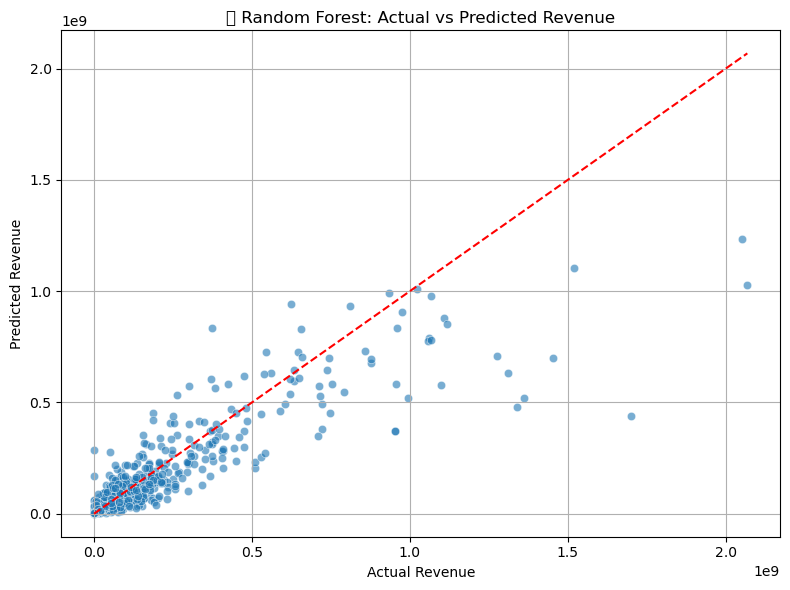

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot: Actual vs Predicted Revenue (Random Forest)
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
preds_rf = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=preds_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('🎬 Random Forest: Actual vs Predicted Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()




C:\Users\rmwc_\AppData\Local\Temp\ipykernel_157476\3508020810.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
C:\Users\rmwc_\AppData\Local\Temp\ipykernel_157476\3508020810.py:11: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\rmwc_\anaconda3\envs\dev\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


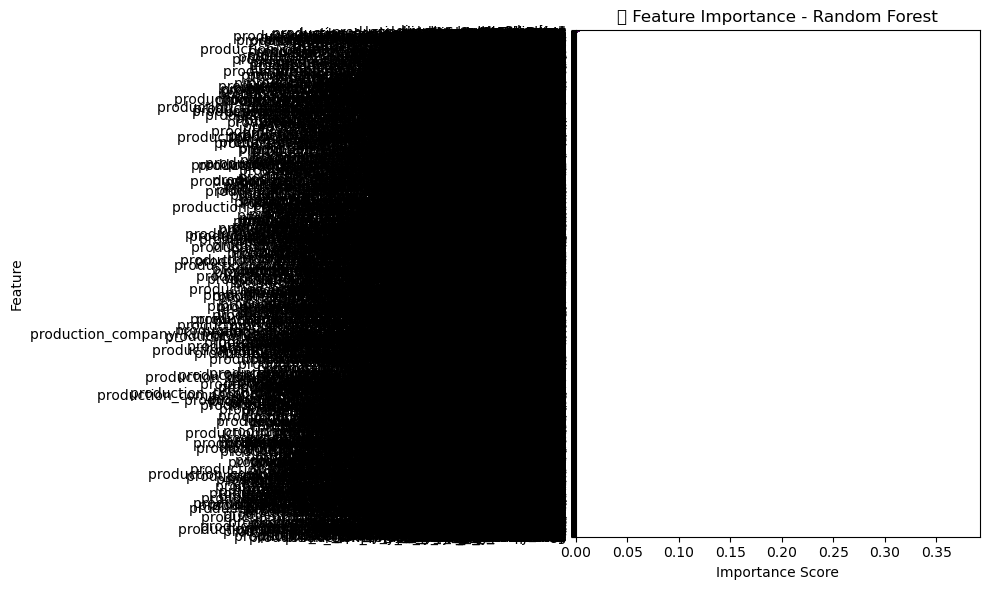

In [ ]:
# 2. Plot: Feature Importance
importances = best_model.feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [29]:
print(df_model.columns.tolist())

['title', 'budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count', 'belongs_to_collection', 'profit', 'profit_margin', 'production_company_1492 Pictures', 'production_company_1821 Pictures', 'production_company_19 Entertainment', 'production_company_1984 Private Defense Contractors', 'production_company_199 Productions', 'production_company_20th Century Fox', 'production_company_20th Century Fox Animation', 'production_company_20th Century Studios', 'production_company_21 Laps Entertainment', 'production_company_2929 Productions', 'production_company_3 Arts Entertainment', 'production_company_3 in the Box', 'production_company_3000 Pictures', 'production_company_308 Enterprises', 'production_company_30WEST', 'production_company_3QU Media', 'production_company_40 Acres and a Mule Filmworks', 'production_company_5150 Action', 'production_company_6th & Idaho Motion Picture Company', 'production_company_777 Films Corporation', 'production_company_87Eleven', 'production_c

In [30]:
genre_columns = [col for col in df_model.columns if col.startswith('genre1_')]

# Use idxmax to find the first genre1_ column with a 1 in it
df_model['genre1'] = df_model[genre_columns].idxmax(axis=1).str.replace('genre1_', '')

In [32]:
import plotly.express as px

#Option 1

fig1 = px.scatter(
    df_model,
    x='budget',
    y='revenue',
    color='genre1',          # color by genre string (e.g., Action, Comedy)
    size='popularity',       # optional: size points by popularity
    hover_data=['title'],    # optional: show movie title on hover
    title='Budget vs Revenue (Colored by Genre)',
    labels={'budget': 'Budget ($)', 'revenue': 'Revenue ($)'}
)

fig1.update_layout(template='plotly_white')
fig1.show()

In [34]:

#Option 2

fig1 = px.scatter(
    df_model,
    x='budget',
    y='revenue',
    color='genre1',  # Now it's a string column like 'Comedy', 'Drama'
    size='popularity',
    hover_data=['title'],
    title='Budget vs Revenue (Colored by Genre)',
    labels={'budget': 'Budget ($)', 'revenue': 'Revenue ($)'}
)
fig1.update_layout(template='plotly_white')
fig1.show()

In [36]:
# 2. Feature Importance Bar Chart
feat_imp = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
fig2 = px.bar(x=feat_imp.values, y=feat_imp.index,
              orientation='h',
              title='Feature Importance (Random Forest)',
              labels={'x': 'Importance Score', 'y': 'Feature'})
fig2.update_layout(yaxis=dict(autorange="reversed"))
fig2.show()

In [38]:
# 3. Box Plot: Revenue by Genre
fig3 = px.box(df_movies, x='genre1', y='revenue', points="all",
              title='Revenue Distribution by Primary Genre')
fig3.update_layout(xaxis_title='Genre', yaxis_title='Revenue')
fig3.show()